## Accessing Copernicus DEM data on Azure

The [Copernicus DEM](https://spacedata.copernicus.eu/explore-more/news-archive/-/asset_publisher/Ye8egYeRPLEs/blog/id/434960) is a digital surface model (DSM), which represents the surface of the Earth including buildings, infrastructure, and vegetation. This DSM is based on radar satellite data acquired during the TanDEM-X Mission, which was funded by a public-private partnership between the German Aerospace Centre (DLR) and Airbus Defence and Space. Copernicus DEM is available at both 30-meter and 90-meter resolution.

Copernicus DEM is available on Azure in cloud-optimized GeoTIFF (COG) format; COG files were sourced from [OpenTopography](https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032021.4326.1).

This notebook demonstrates access to Copernicus DEM data from blob storage on Azure, including (1) finding the Copernicus DEM tile corresponding to a lat/lon coordinate and (2) opening and plotting the tile.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-copernicus-dem](http://aka.ms/ai4edata-copernicus-dem).

You can also use the [Planetary Computer search API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) ([example](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30#Example-Notebook)) to search for Copernicus DEM data.


### Imports and environment

In [25]:
import os
import math
import requests
import tempfile
import wget
import csv

import rasterio as rio
from rasterio import plot
from matplotlib import pyplot as plt

account_name = 'elevationeuwest'
container_name = 'copernicus-dem'
account_url = 'https://' + account_name + '.blob.core.windows.net'
blob_root = account_url + '/' + container_name + '/'

cdem_content_extension = '.tif'

# List of blobs and their lat/lon ranges, as left/bottom/right/top
#
# One for the 30m DEM...
cdem_30_extents_url = account_url + '/' + container_name + '/' + 'index/copernicus-dem-30-bounds.csv'

# ...and one for the 90m DEM.
cdem_90_extents_url = account_url + '/' + container_name + '/' + 'index/copernicus-dem-90-bounds.csv'

# Load the lat/lon table for the 30m DEM
temp_dir = os.path.join(tempfile.gettempdir(),'copernicus-dem')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,cdem_30_extents_url.split('/')[-1])
if not os.path.isfile(fn):
  wget.download(cdem_30_extents_url, fn, bar=None)

# Load this file into a table, where each row is (name,left,bottom,right,top)
with open(fn, newline='') as f:
    reader = csv.reader(f)
    cdem_30_tile_extents = list(reader)

# Remove the header and convert str to float
cdem_30_tile_extents = cdem_30_tile_extents[1:]
for i in range(0,len(cdem_30_tile_extents)):    
    for j in range(1,5):
        cdem_30_tile_extents[i][j] = float(cdem_30_tile_extents[i][j])

### Functions

In [32]:
def lat_lon_to_copernicus_dem_tile(lat,lon,extents):
    """
    Get the tile path corresponding to the given lat/lon from the table in "extents"
    """
    
    i_tile = None
    for i in range(0,len(extents)):
        found_matching_tile = \
        lat >= extents[i][2] \
        and lon <= extents[i][3] \
        and lat <= extents[i][4] \
        and lon >= extents[i][1]
        if found_matching_tile:
            i_tile = i
            break
            
    assert i_tile is not None, 'Could not find tile for coordinate {},{}'.format(lat,lon)
    blob_name = extents[i_tile][0]
    return blob_name

### Find the tile for a known lat/lon

In [33]:
# Interesting places for looking at DEM data
everest = [27.9881,86.9250]
seattle = [47.6062,-122.3321]
grand_canyon = [36.101690, -112.107676]
mount_fuji = [35.3606, 138.7274]
mont_blanc = [45.832778, 6.865000]
invalid = [-15.1,41]

tile_of_interest = mount_fuji

tile_name = lat_lon_to_copernicus_dem_tile(tile_of_interest[0],tile_of_interest[1],cdem_30_tile_extents)
url = blob_root + tile_name
print('Plotting tile at:\n{}'.format(url))

Plotting tile at:
https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP30_hh/Copernicus_DSM_COG_10_N35_00_E138_00_DEM.tif


### Plot the tile

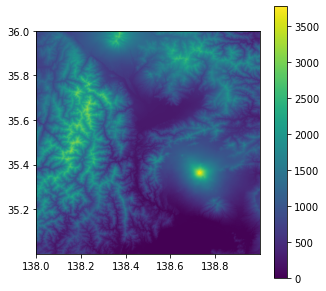

In [34]:
src = rio.open(url)
d = src.read(1)
fig, ax = plt.subplots(figsize=(5, 5))

# create a hidden image so we can add a colorbar
image_hidden = ax.imshow(d,cmap='viridis')

image = rio.plot.show(d, 
                      transform=src.transform, 
                      ax=ax, 
                      cmap='viridis')

fig.colorbar(image_hidden, ax=ax);